# Perception of Minority Groups in Switzerland
## Motivation
For the final project of the Social Computing course at the University of Zurich, we created a dataset of comments extracted from Reddit in regards to the three target groups outlined in [this study](https://www.bfs.admin.ch/bfs/en/home/statistics/population/migration-integration/diversity-coexistence-switzerland/attitude-towards-target-groups.html) conducted by the Swiss Federal Statistic Office or Bundesamt fur Statistik (BFS) and performed a sentiment analysis using the Google Perspective API to see whether the perception of minority groups in Switzerland on Reddit matches the analysis done by the BFS. 

## Analysis Part 1: Comment Analysis
From the file which contains the cleaned data with all the years combined, we will use the Google Perspective API to score the comments. We will query the API for toxicity, severe toxicity, identitity attack, insult, profanity and threat. We will repeat this for the four groups (Jewish People, Black People, Muslim People and the Control).

In [ ]:
API_KEY = ''

In [3]:
from csv import writer, reader
from googleapiclient import discovery

import json
import time

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

def comment_analyzer(input_file, output_file):
    with open (input_file) as read_obj, \
        open(output_file, 'w', newline='') as write_obj:

        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)

        overall_toxicity = 0
        overall_severe_toxicity = 0
        overall_identity_attack = 0
        overall_insult = 0
        overall_profanity = 0
        overall_threat = 0

        no_of_comments = 0

        for row in csv_reader:
            comment = row[4]
            if comment:

                try:
                    analyze_request = {
                        'comment': { 'text': comment },
                        'requestedAttributes': {'TOXICITY': {}, 'SEVERE_TOXICITY':{}, 'IDENTITY_ATTACK':{}, 'INSULT':{}, 'PROFANITY':{}, 'THREAT':{}}
                        }
                    response = client.comments().analyze(body=analyze_request).execute()
                except Exception as e:
                    print(e)
                    continue

                toxicity = response["attributeScores"]["TOXICITY"]["summaryScore"]["value"]
                overall_toxicity += toxicity
                
                severe_toxicity = response["attributeScores"]["SEVERE_TOXICITY"]["summaryScore"]["value"]
                overall_severe_toxicity += severe_toxicity
                
                identity_attack = response["attributeScores"]["IDENTITY_ATTACK"]["summaryScore"]["value"]
                overall_identity_attack += identity_attack
                
                insult = response["attributeScores"]["INSULT"]["summaryScore"]["value"]
                overall_insult += insult
                
                profanity = response["attributeScores"]["PROFANITY"]["summaryScore"]["value"]
                overall_profanity += profanity
                
                threat = response["attributeScores"]["THREAT"]["summaryScore"]["value"]
                overall_threat += threat

                no_of_comments += 1

                for item in [toxicity,severe_toxicity,identity_attack,insult,profanity,threat]:
                    row.append(item)

                # Add the updated row to the output file
                csv_writer.writerow(row)

                # print(comment, toxicity, severe_toxicity, identity_attack, insult, profanity, threat)
                # rate limit API requests
                time.sleep(1)
            
        overall_toxicity = overall_toxicity/no_of_comments
        overall_severe_toxicity = severe_toxicity/no_of_comments
        overall_identity_attack = identity_attack/no_of_comments
        overall_insult = overall_insult/no_of_comments
        overall_profanity = overall_profanity/no_of_comments
        overall_threat = overall_threat/no_of_comments

        print(output_file)
        print(no_of_comments)
        print(f"TOXICITY: {overall_toxicity} \nSEVERE TOXICTY: {overall_severe_toxicity} \nIDENTITY_ATTACK: {overall_identity_attack} \nINSULT: {overall_insult} \nPROFANITY: {overall_profanity} \nTHREAT: {overall_threat}")


In [ ]:
# Jewish Group
comment_analyzer('Jews_concat.csv', 'Jews_concat_scored_2.csv')

In [ ]:
# Black People Group
comment_analyzer('BlackPeople_concat.csv', 'BlackPeople_concat_scored.csv')

In [ ]:
# Muslim Group
comment_analyzer('Muslim_concat.csv', 'Muslim_concat_scored.csv')

In [ ]:
# Control Group
comment_analyzer('Control_concat.csv', 'Control_concat_scored.csv')

## Initial Comment Count
All the comments were scored, an exception occured if the language was not able to be understood. Due to rate limiting of the API only one request per second could be made, this took a long time (>40 mins) to score the data for the "Black People" group.

The comment count for each group is:
1. Jewish People: 243
1. Black People: 2327
1. Muslim People: 832
1. Control: 854

## Checking Scores by Year
Since we want to compare to the official BFS study, we need to get values that show a yearly distribution of the perception. We do this by taking the averages of the comments per year.

In [3]:
def check_score_by_year(file):
    scores = {
        '2018':{'comment_count':0,'toxicity':0,'severe_toxicity':0,'identity_attack':0,'insult':0,'profanity':0,'threat':0},
        '2019':{'comment_count':0,'toxicity':0,'severe_toxicity':0,'identity_attack':0,'insult':0,'profanity':0,'threat':0},
        '2020':{'comment_count':0,'toxicity':0,'severe_toxicity':0,'identity_attack':0,'insult':0,'profanity':0,'threat':0},
        '2021':{'comment_count':0,'toxicity':0,'severe_toxicity':0,'identity_attack':0,'insult':0,'profanity':0,'threat':0},
        '2022':{'comment_count':0,'toxicity':0,'severe_toxicity':0,'identity_attack':0,'insult':0,'profanity':0,'threat':0}
        }

    with open(file) as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            year = row[6]

            toxicity = float(row[7])
            severe_toxicity = float(row[8])
            identity_attack = float(row[9])
            insult = float(row[10])
            profanity = float(row[11])
            threat = float(row[12])

            scores[year]['comment_count'] += 1
            scores[year]['toxicity'] += toxicity
            scores[year]['severe_toxicity'] += severe_toxicity
            scores[year]['identity_attack'] += identity_attack
            scores[year]['insult'] += insult
            scores[year]['profanity'] += profanity
            scores[year]['threat'] += threat
    
    # Calculate and display averages
    for year in ['2018', '2019', '2020', '2021', '2022']:
        if scores[year]['comment_count'] != 0:
            scores[year]['toxicity'] = scores[year]['toxicity']/scores[year]['comment_count']
            scores[year]['severe_toxicity'] = scores[year]['severe_toxicity']/scores[year]['comment_count']
            scores[year]['identity_attack'] = scores[year]['identity_attack']/scores[year]['comment_count']
            scores[year]['insult'] = scores[year]['insult']/scores[year]['comment_count']
            scores[year]['profanity'] = scores[year]['profanity']/scores[year]['comment_count']
            scores[year]['threat'] = scores[year]['threat']/scores[year]['comment_count']

    print(file)
    print(scores)
    return scores

In [15]:
# Jewish Group
jewish_scores = check_score_by_year('Jews_concat_scored.csv')

Jews_concat_scored.csv
{'2018': {'comment_count': 14, 'toxicity': 0.32147359535714287, 'severe_toxicity': 0.20881121628571428, 'identity_attack': 0.4858012835714285, 'insult': 0.2680820296428571, 'profanity': 0.17121629464285712, 'threat': 0.25683451714285715}, '2019': {'comment_count': 0, 'toxicity': 0, 'severe_toxicity': 0, 'identity_attack': 0, 'insult': 0, 'profanity': 0, 'threat': 0}, '2020': {'comment_count': 64, 'toxicity': 0.39114848671874997, 'severe_toxicity': 0.26954105289062497, 'identity_attack': 0.45569376818749996, 'insult': 0.33188901404687493, 'profanity': 0.24302748473437497, 'threat': 0.250788250734375}, '2021': {'comment_count': 54, 'toxicity': 0.37017371787037034, 'severe_toxicity': 0.25939890744444444, 'identity_attack': 0.4792941127037036, 'insult': 0.3106054294444444, 'profanity': 0.24187037203703707, 'threat': 0.2803462516481481}, '2022': {'comment_count': 110, 'toxicity': 0.3780047959909089, 'severe_toxicity': 0.2712988376999999, 'identity_attack': 0.512787964

In [16]:
# Black People Group
black_scores = check_score_by_year('BlackPeople_concat_scored.csv')

BlackPeople_concat_scored.csv
{'2018': {'comment_count': 0, 'toxicity': 0, 'severe_toxicity': 0, 'identity_attack': 0, 'insult': 0, 'profanity': 0, 'threat': 0}, '2019': {'comment_count': 188, 'toxicity': 0.32119203144148933, 'severe_toxicity': 0.20123335279255322, 'identity_attack': 0.3220485142712766, 'insult': 0.295043578787234, 'profanity': 0.20642770446276598, 'threat': 0.23058073637765952}, '2020': {'comment_count': 1335, 'toxicity': 0.36436791458052453, 'severe_toxicity': 0.24118654181048668, 'identity_attack': 0.3891979511423213, 'insult': 0.3312536540832213, 'profanity': 0.2501316309460673, 'threat': 0.22868165542846428}, '2021': {'comment_count': 504, 'toxicity': 0.3067026572763894, 'severe_toxicity': 0.19379571210198426, 'identity_attack': 0.30039216047619016, 'insult': 0.2722456769692461, 'profanity': 0.19964104175198427, 'threat': 0.23492598074603166}, '2022': {'comment_count': 299, 'toxicity': 0.3008797977591974, 'severe_toxicity': 0.19054842643812706, 'identity_attack': 

In [17]:
# Muslim People Group
muslim_scores = check_score_by_year('Muslim_concat_scored.csv')

Muslim_concat_scored.csv
{'2018': {'comment_count': 12, 'toxicity': 0.457400145, 'severe_toxicity': 0.34388657333333333, 'identity_attack': 0.38327586366666666, 'insult': 0.3690420904166667, 'profanity': 0.41561191666666675, 'threat': 0.23790443000000003}, '2019': {'comment_count': 0, 'toxicity': 0, 'severe_toxicity': 0, 'identity_attack': 0, 'insult': 0, 'profanity': 0, 'threat': 0}, '2020': {'comment_count': 50, 'toxicity': 0.29243901791999993, 'severe_toxicity': 0.17866297611999996, 'identity_attack': 0.3562480768200001, 'insult': 0.25447656106, 'profanity': 0.17053668040000006, 'threat': 0.18052559318}, '2021': {'comment_count': 667, 'toxicity': 0.3591136304092951, 'severe_toxicity': 0.23519381947560725, 'identity_attack': 0.4119726254212898, 'insult': 0.3153465716334332, 'profanity': 0.2183200031065967, 'threat': 0.25115143615592234}, '2022': {'comment_count': 102, 'toxicity': 0.37666959468627464, 'severe_toxicity': 0.2646259656078432, 'identity_attack': 0.45962789986274516, 'insu

In [8]:
# Control Group
control_scores = check_score_by_year('Control_concat_scored.csv')

Control_concat_scored.csv
{'2018': {'comment_count': 64, 'toxicity': 0.19088990187500005, 'severe_toxicity': 0.111263203421875, 'identity_attack': 0.12259018459374997, 'insult': 0.16233649012500004, 'profanity': 0.14845519996875, 'threat': 0.15345803820312498}, '2019': {'comment_count': 265, 'toxicity': 0.24679616578603777, 'severe_toxicity': 0.14703204581501894, 'identity_attack': 0.1618315299698114, 'insult': 0.20942221956792453, 'profanity': 0.18978729419283008, 'threat': 0.19476958745283038}, '2020': {'comment_count': 161, 'toxicity': 0.21431897088819862, 'severe_toxicity': 0.13606734402857146, 'identity_attack': 0.14191794530434776, 'insult': 0.17995072453416144, 'profanity': 0.1660961583229814, 'threat': 0.21299271125465843}, '2021': {'comment_count': 174, 'toxicity': 0.17251643924137927, 'severe_toxicity': 0.10117002498045977, 'identity_attack': 0.12768987066666668, 'insult': 0.1384378496293103, 'profanity': 0.1276537557356321, 'threat': 0.16502731154310346}, '2022': {'comment_c

In [1]:
def get_average_score_per_year(data):
    results = {}
    for year in data:
        score = (data[year]['toxicity'] + data[year]['severe_toxicity'] + data[year]['identity_attack'] + data[year]['insult'] + data[year]['profanity'] + data[year]['threat'])/6
        print(f"YEAR: {year} SCORE: {score}")
        results[year] = score
    
    return results

In [19]:
print("Jewish Group:")
get_average_score_per_year(jewish_scores)
print("Black Group:")
get_average_score_per_year(black_scores)
print("Muslim Group:")
get_average_score_per_year(muslim_scores)
print("Control Group")
get_average_score_per_year(control_scores)

Jewish Group:
YEAR: 2018 SCORE: 0.28536982277380946
YEAR: 2019 SCORE: 0.0
YEAR: 2020 SCORE: 0.32368134288541667
YEAR: 2021 SCORE: 0.3236147985246913
YEAR: 2022 SCORE: 0.33231762558636363
Black Group:
YEAR: 2018 SCORE: 0.0
YEAR: 2019 SCORE: 0.2627543196888298
YEAR: 2020 SCORE: 0.3008032246651809
YEAR: 2021 SCORE: 0.2512838715536376
YEAR: 2022 SCORE: 0.24800222435618727
Muslim Group:
YEAR: 2018 SCORE: 0.3678535031805556
YEAR: 2019 SCORE: 0.0
YEAR: 2020 SCORE: 0.23881481758333334
YEAR: 2021 SCORE: 0.2985163477003574
YEAR: 2022 SCORE: 0.3205764591944445
Control Group
YEAR: 2018 SCORE: 0.14816550303125
YEAR: 2019 SCORE: 0.19160647379740883
YEAR: 2020 SCORE: 0.17522397572215317
YEAR: 2021 SCORE: 0.1387492086327586
YEAR: 2022 SCORE: 0.12915136281825393


## Iteration on Method
The results display higher levels of toxicity than the control group, which makes sense based on our hypothesis, however scanning the comments shows us that there still may be irrelevant comments being scored, which will alter the averages in the end. We realize further cleaning of the data is necessary. For this we will perform keyword extraction using nltk and define a keyword dictionary in order to check which comments contain keywords that are relevant to us. We will write the relevant comments to a new file and then check the scores by year again.

### Keyword Extraction with "rake_nltk" + Comment Cleaning with Keywords

In [5]:
import json
import time

from rake_nltk import Rake
from csv import writer, reader
from googleapiclient import discovery

rake_nltk_var = Rake()

def keyword_comment_cleaning(input_file, output_file, defined_keywords):
    with open (input_file) as read_obj, \
        open(output_file, 'w', newline='') as write_obj:

        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)

        # Skip header
        next(csv_reader)
        
        comment_count = 0
        for row in csv_reader:
            comment = row[4]

            # Check extracted keywords to see what should be added to our dictionary
            rake_nltk_var.extract_keywords_from_text(comment)
            keyword_extracted = rake_nltk_var.get_ranked_phrases()
            print(keyword_extracted)

            # Only save the comments which contain the keywords we are searching for
            for keyword in defined_keywords:
                if keyword in comment:
                    csv_writer.writerow(row)
                    comment_count += 1
                    break
    
    print(comment_count)

In [4]:
jewish_keywords = ["jew", "jewish", "kippah", "israel", "israeli", "zionism", "zionist", "antisemitism", "anti-semitism", "semetic", "sabbath", "religion", "torah", "synagogue", "nazi", "palestine", "wiedikon", "orthodox"] 
black_keywords = ["black people", "people of color", "poc", "blm", "black lives matter", "black racism", "black", "brown"]
muslim_keywords = ["muslim", "islam", "islaam", "hijab", "hijaab", "islamophobia", "burqa", "niqab", "quran", "turk", "albanian", "bosnian", "cloth", "scarf", "mosque", "minaret", "palestine", "practicing", "arab", "prophet", "brown", "women", "face covering", "jihad"] 
general_keywords = ["foreign", "foreigners", "left", "svp", "xenophobia", "news", "view", "opinion", "fundamental", "extremist", "extremism", "religion", "religious", "race", "racist", "racism", "racial", "xenophobia", "leave", "rural", "city", "peace", "they", "immigration", "attack", "look", "bad", "stare", "discrimination", "border", "policy", "like", "naturalisation", "death", "history", "homeland", "tourist", "job", "europe", "diversity", "referendum", "ban", "swiss", "switzerland", "integrate", "integration", "treat", "facist", "god"]

In [ ]:
# Jewish group
keyword_comment_cleaning('Jews_concat_scored.csv', 'Jews_concat_scored_cleaned.csv', jewish_keywords+general_keywords)

In [ ]:
# Black group
keyword_comment_cleaning('BlackPeople_concat_scored.csv', 'BlackPeople_concat_scored_cleaned.csv', black_keywords+general_keywords)

In [ ]:
# Muslim group
keyword_comment_cleaning('Muslim_concat_scored.csv', 'Muslim_concat_scored_cleaned.csv', muslim_keywords+general_keywords)

In [6]:
# Get new data points
jewish_scores_2 = check_score_by_year('Jews_concat_scored_cleaned.csv')
black_scores_2 = check_score_by_year('BlackPeople_concat_scored_cleaned.csv')
muslim_scores_2 = check_score_by_year('Muslim_concat_scored_cleaned.csv')

Jews_concat_scored_cleaned.csv
{'2018': {'comment_count': 11, 'toxicity': 0.3290302622727273, 'severe_toxicity': 0.21218136672727272, 'identity_attack': 0.49205529181818175, 'insult': 0.2856324022727272, 'profanity': 0.18140642136363636, 'threat': 0.24412992545454545}, '2019': {'comment_count': 0, 'toxicity': 0, 'severe_toxicity': 0, 'identity_attack': 0, 'insult': 0, 'profanity': 0, 'threat': 0}, '2020': {'comment_count': 48, 'toxicity': 0.4173318035416667, 'severe_toxicity': 0.2926722983958333, 'identity_attack': 0.5436139887916666, 'insult': 0.3520944281458334, 'profanity': 0.24055109308333333, 'threat': 0.28157809460416666}, '2021': {'comment_count': 40, 'toxicity': 0.42083435150000004, 'severe_toxicity': 0.3108975114, 'identity_attack': 0.588388438125, 'insult': 0.3531301540249999, 'profanity': 0.27397559309999997, 'threat': 0.32670182432499995}, '2022': {'comment_count': 91, 'toxicity': 0.4169666933406592, 'severe_toxicity': 0.30610085553846145, 'identity_attack': 0.5849504997252

In [9]:
# Get new values per year
print("Jewish Group:")
jewish_yearly_values = get_average_score_per_year(jewish_scores_2)
print("Black Group:")
black_yearly_values = get_average_score_per_year(black_scores_2)
print("Muslim Group:")
muslim_yearly_values = get_average_score_per_year(muslim_scores_2)
print("Control Group")
control_yearly_values = get_average_score_per_year(control_scores)

Jewish Group:
YEAR: 2018 SCORE: 0.2907392783181818
YEAR: 2019 SCORE: 0.0
YEAR: 2020 SCORE: 0.35464028442708334
YEAR: 2021 SCORE: 0.37898797874583323
YEAR: 2022 SCORE: 0.37007039048901097
Black Group:
YEAR: 2018 SCORE: 0.0
YEAR: 2019 SCORE: 0.30199669123669465
YEAR: 2020 SCORE: 0.3357746664597505
YEAR: 2021 SCORE: 0.28688494245393376
YEAR: 2022 SCORE: 0.28652813573577235
Muslim Group:
YEAR: 2018 SCORE: 0.4038953422222223
YEAR: 2019 SCORE: 0.0
YEAR: 2020 SCORE: 0.2948947258205128
YEAR: 2021 SCORE: 0.3348323866915177
YEAR: 2022 SCORE: 0.38974709333552626
Control Group
YEAR: 2018 SCORE: 0.14816550303125
YEAR: 2019 SCORE: 0.19160647379740883
YEAR: 2020 SCORE: 0.17522397572215317
YEAR: 2021 SCORE: 0.1387492086327586
YEAR: 2022 SCORE: 0.12915136281825393


## Final Comment Count
The comment count for each group is:
1. Jewish People: 191
1. Black People: 1529
1. Muslim People: 609
1. Control: 854

## Baseline Analysis
It appears as if the results did get higher after removing comments which did not contain the keywords. Overall there seems to be a consistent trend in toxcity towards all the groups, which appear generally higher than compared to the control group. 

## Graphing Values

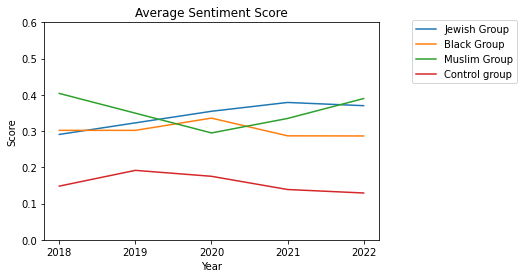

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = []
j_y = [] 
b_y = []
m_y = []
c_y = []

for key in control_yearly_values:
    x.append(key)
    j_y.append(jewish_yearly_values[key])
    b_y.append(black_yearly_values[key])
    m_y.append(muslim_yearly_values[key])
    c_y.append(control_yearly_values[key])

def interpolate_zero_values(data, method="linear"):
    a = pd.Series(data)
    a.replace(0, np.NaN, inplace=True)
    data = a.interpolate(method=method, limit=2)
    return data

j_y = interpolate_zero_values(j_y)
b_y = interpolate_zero_values(b_y, method="backfill") # backfill due to missing initial values
m_y = interpolate_zero_values(m_y)

fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Score")

plt.ylim(0,0.6)

ax.plot(x, j_y, label="Jewish Group")
ax.plot(x, b_y, label="Black Group")
ax.plot(x, m_y, label="Muslim Group")
ax.plot(x, c_y, label="Control group")

plt.title(label="Average Sentiment Score")

plt.legend()
plt.legend(loc=(1.1, 0.72))

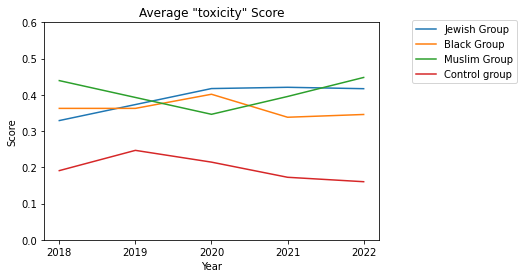

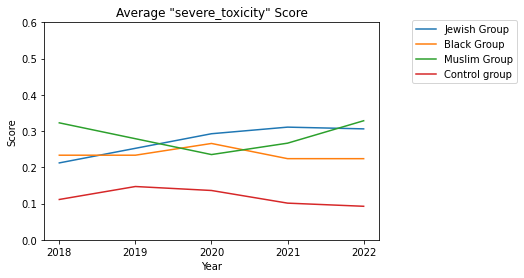

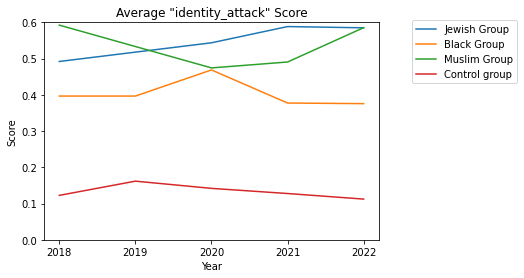

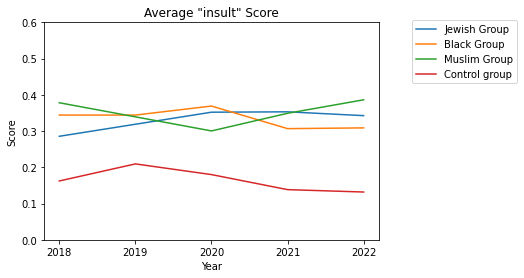

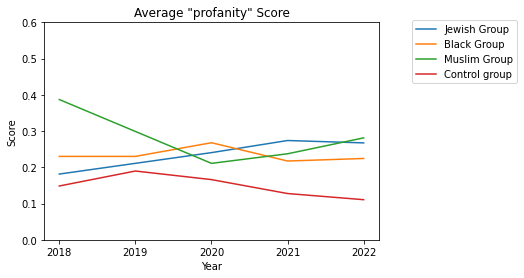

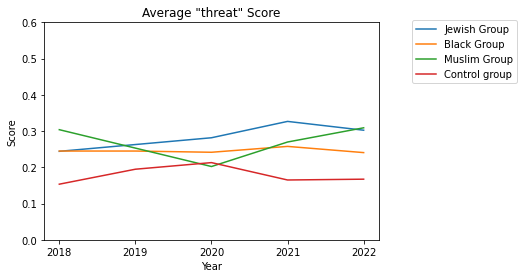

In [68]:
# Define sentiments to great graphs for
measures = ["toxicity", "severe_toxicity", "identity_attack", "insult", "profanity", "threat"]

for measure in measures:
    x = []
    j_y = [] 
    b_y = []
    m_y = []
    c_y = []
    for key in control_scores:
        x.append(key)
        j_y.append(jewish_scores_2[key][measure])
        b_y.append(black_scores_2[key][measure])
        m_y.append(muslim_scores_2[key][measure])
        c_y.append(control_scores[key][measure])

    j_y = interpolate_zero_values(j_y)
    b_y = interpolate_zero_values(b_y, method="backfill") # backfill due to missing initial values
    m_y = interpolate_zero_values(m_y)

    fig, ax = plt.subplots()
    ax.set_xlabel("Year")
    ax.set_ylabel("Score")

    plt.ylim(0,0.6)

    ax.plot(x, j_y, label="Jewish Group")
    ax.plot(x, b_y, label="Black Group")
    ax.plot(x, m_y, label="Muslim Group")
    ax.plot(x, c_y, label="Control group")

    plt.title(label=f'Average "{measure}" Score')

    plt.legend()
    plt.legend(loc=(1.1, 0.72))